<a href="https://colab.research.google.com/github/Aatmaj-Zephyr/CSM/blob/main/lab/CSM_exp_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy

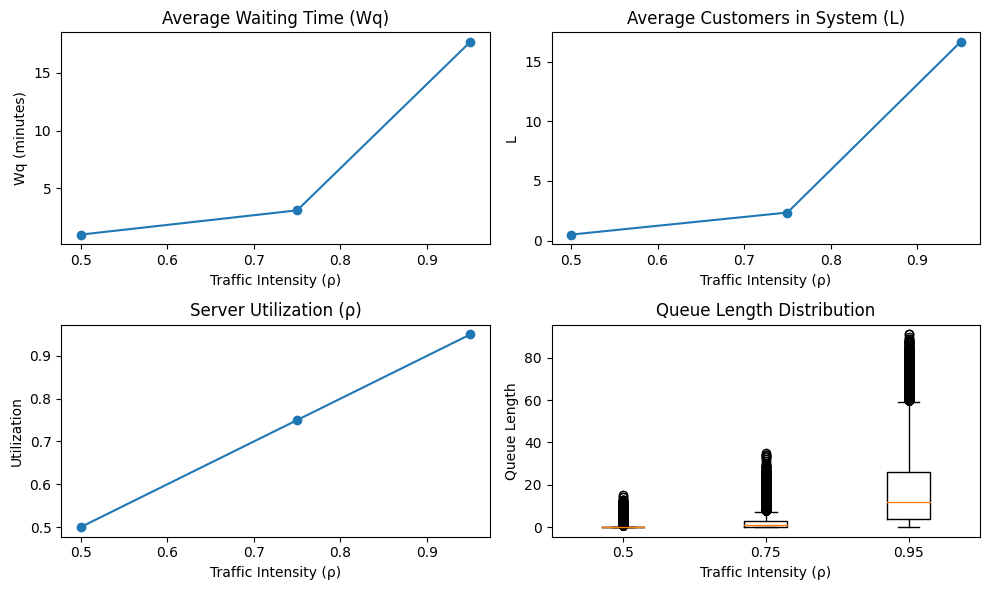

In [ ]:
import simpy
import random
import matplotlib.pyplot as plt

# Parameters
service_rate = 1.0  # Service rate (mu) is fixed at 1 customer per minute
simulation_time = 100000  # Total simulation time in minutes (100,000 minutes)

# Initialize metrics for different traffic intensities
traffic_intensities = [0.5, 0.75, 0.95]
average_waiting_times = []
average_customers_in_system = []
server_utilizations = []
queue_length_distributions = []
waiting_time_distributions = []

# Define the M/M/1 Queue Simulation class
class MM1QueueSimulation:
    def __init__(self, env, arrival_rate):
        self.env = env  # SimPy environment
        self.server = simpy.Resource(env, capacity=1)  # Define a server with a capacity of 1 (single server)
        self.arrival_rate = arrival_rate  # Arrival rate (lambda), based on traffic intensity
        self.wait_times = []  # List to store waiting times for each customer
        self.queue_lengths = []  # List to store queue lengths at different points in time
        self.customer_count = 0  # Counter for total number of customers

    def arrival(self):
        while True:  # Loop to continuously generate customer arrivals
            # Inter-arrival time: Time between arrivals follows an exponential distribution
            inter_arrival_time = random.expovariate(self.arrival_rate)
            yield self.env.timeout(inter_arrival_time)  # Simulate the passing of inter-arrival time

            # Arrival: Customer arrives at the system
            self.customer_count += 1  # Increment the total customer count
            queue_length = len(self.server.queue)  # Get the current queue length
            self.queue_lengths.append(queue_length)  # Record the queue length
            arrival_time = self.env.now  # Record the current time as the arrival time
            self.env.process(self.service(arrival_time))  # Start the service process for this customer

    def service(self, arrival_time):
        with self.server.request() as request:  # Requesting access to the server (start of service)
            yield request  # Wait until the server is available

            # Calculate the waiting time (time spent in queue before service)
            waiting_time = self.env.now - arrival_time
            self.wait_times.append(waiting_time)  # Record the waiting time

            # Service time: Time to serve a customer follows an exponential distribution
            service_time = random.expovariate(service_rate)
            yield self.env.timeout(service_time)  # Simulate the passing of service time

    def run_simulation(self):
        # Start the arrival process
        self.env.process(self.arrival())
        # Run the simulation for the specified simulation time
        self.env.run(until=simulation_time)

# Running simulations for different traffic intensities
for rho in traffic_intensities:
    # Calculate the arrival rate (lambda) based on the traffic intensity (rho)
    arrival_rate = rho * service_rate
    # Create a SimPy environment
    env = simpy.Environment()
    # Initialize the M/M/1 queue simulation with the environment and arrival rate
    simulation = MM1QueueSimulation(env, arrival_rate)
    # Run the simulation
    simulation.run_simulation()

    # Calculate the average waiting time (Wq)
    avg_wait_time = sum(simulation.wait_times) / len(simulation.wait_times)
    # Calculate the average number of customers in the system (L)
    avg_customers_in_system = sum(simulation.queue_lengths) / len(simulation.queue_lengths)
    # Server utilization is the same as traffic intensity (rho)
    server_utilization = rho
    # Get the queue length distribution
    queue_length_distribution = simulation.queue_lengths
    # Get the waiting time distribution
    waiting_time_distribution = simulation.wait_times

    # Store the calculated metrics in their respective lists
    average_waiting_times.append(avg_wait_time)
    average_customers_in_system.append(avg_customers_in_system)
    server_utilizations.append(server_utilization)
    queue_length_distributions.append(queue_length_distribution)
    waiting_time_distributions.append(waiting_time_distribution)

# Plotting results
plt.figure(figsize=(10, 6))  # Create a figure with a specific size

# Plot for Average Waiting Time (Wq)
plt.subplot(2, 2, 1)  # Subplot for Wq
plt.plot(traffic_intensities, average_waiting_times, marker='o')  # Line plot with markers
plt.title('Average Waiting Time (Wq)')  # Title of the plot
plt.xlabel('Traffic Intensity (ρ)')  # Label for x-axis
plt.ylabel('Wq (minutes)')  # Label for y-axis

# Plot for Average Number of Customers in the System (L)
plt.subplot(2, 2, 2)  # Subplot for L
plt.plot(traffic_intensities, average_customers_in_system, marker='o')  # Line plot with markers
plt.title('Average Customers in System (L)')  # Title of the plot
plt.xlabel('Traffic Intensity (ρ)')  # Label for x-axis
plt.ylabel('L')  # Label for y-axis

# Plot for Server Utilization (ρ)
plt.subplot(2, 2, 3)  # Subplot for server utilization
plt.plot(traffic_intensities, server_utilizations, marker='o')  # Line plot with markers
plt.title('Server Utilization (ρ)')  # Title of the plot
plt.xlabel('Traffic Intensity (ρ)')  # Label for x-axis
plt.ylabel('Utilization')  # Label for y-axis

# Plot for Queue Length Distribution
plt.subplot(2, 2, 4)  # Subplot for queue length distribution
plt.boxplot(queue_length_distributions, labels=[str(rho) for rho in traffic_intensities])  # Box plot
plt.title('Queue Length Distribution')  # Title of the plot
plt.xlabel('Traffic Intensity (ρ)')  # Label for x-axis
plt.ylabel('Queue Length')  # Label for y-axis

plt.tight_layout()  # Adjust layout to prevent overlap of subplots
plt.show()  # Display the plots


Average Waiting Time (Wq): 252.77 minutes
Average Number of Vehicles in System (L): 1169.68
Server Utilization (ρ): 1.00


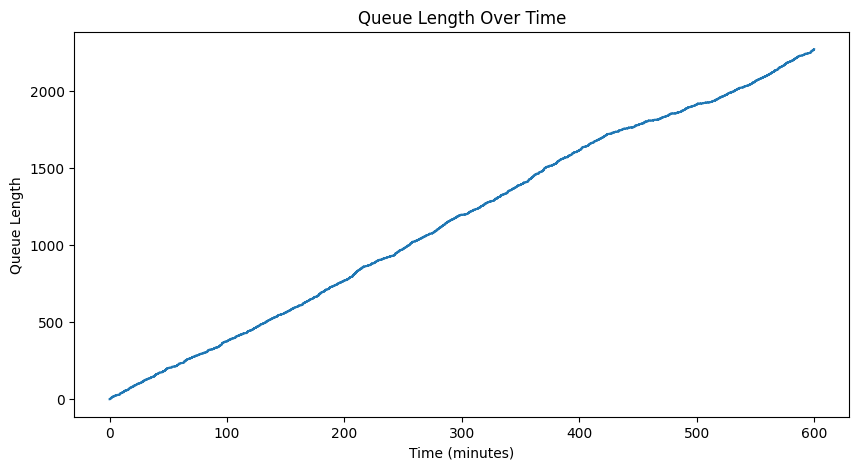

In [ ]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Simulation Parameters
arrival_rate = 5  # vehicles per minute
peak_service_mean = 0.5  # minutes
peak_service_std = 0.1  # minutes
off_peak_service_mean = 1.0  # minutes
off_peak_service_std = 0.2  # minutes
peak_start_time = 7 * 60  # 7:00 AM in minutes
peak_end_time = 9 * 60  # 9:00 AM in minutes
simulation_time = 10 * 60  # 10 hours total (in minutes)

# Performance Metrics
waiting_times = []
queue_lengths = []
utilization_times = []
arrival_times = []

class TollBoothSimulation:
    def __init__(self, env):
        self.env = env
        self.server = simpy.Resource(env, capacity=1)  # Single toll booth
        self.total_service_time = 0

    def service_time(self):
        """Determine the service time based on peak/off-peak hours."""
        if peak_start_time <= self.env.now < peak_end_time:  # Peak hours
            return random.gauss(peak_service_mean, peak_service_std)
        else:  # Off-peak hours
            return random.gauss(off_peak_service_mean, off_peak_service_std)

    def arrival(self):
        while True:
            # Time between arrivals follows an exponential distribution
            inter_arrival_time = random.expovariate(arrival_rate)
            yield self.env.timeout(inter_arrival_time)
            arrival_time = self.env.now
            arrival_times.append(arrival_time)

            self.env.process(self.service(arrival_time))

    def service(self, arrival_time):
        with self.server.request() as request:
            queue_length = len(self.server.queue)
            queue_lengths.append(queue_length)

            yield request  # Wait until the toll booth is free

            # Calculate waiting time
            waiting_time = self.env.now - arrival_time
            waiting_times.append(waiting_time)

            # Simulate service time
            service_time = max(0, self.service_time())  # Ensure no negative service times
            utilization_times.append(service_time)
            yield self.env.timeout(service_time)
            self.total_service_time += service_time

def run_simulation():
    env = simpy.Environment()
    simulation = TollBoothSimulation(env)
    env.process(simulation.arrival())
    env.run(until=simulation_time)

    # Calculate performance metrics
    avg_waiting_time = np.mean(waiting_times)
    avg_customers_in_system = np.mean(queue_lengths)
    server_utilization = sum(utilization_times) / simulation_time

    return avg_waiting_time, avg_customers_in_system, server_utilization

# Run the simulation
avg_waiting_time, avg_customers_in_system, server_utilization = run_simulation()

# Print the performance metrics
print(f"Average Waiting Time (Wq): {avg_waiting_time:.2f} minutes")
print(f"Average Number of Vehicles in System (L): {avg_customers_in_system:.2f}")
print(f"Server Utilization (ρ): {server_utilization:.2f}")

# Plotting the queue length over time
plt.figure(figsize=(10, 5))
plt.plot(arrival_times, queue_lengths, drawstyle='steps-post')
plt.xlabel('Time (minutes)')
plt.ylabel('Queue Length')
plt.title('Queue Length Over Time')
plt.show()


Postlab

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set the random seed for reproducibility
np.random.seed(42)


In [ ]:
# Define parameters for the M/M/1 and M/M/3 queues
# Check-in Counter (M/M/1)
lambda_checkin = 3  # Arrival rate
mu_checkin = 4      # Service rate

# Service Desk (M/M/1)
lambda_servicedesk = 3
mu_servicedesk = 5

# Specialized Service Counters (M/M/3)
num_counters = 2
lambda_specialized = [2, 4]  # Arrival rates for each counter
mu_specialized = [6, 6]      # Service rates for each counter


In [ ]:
def simulate_queue(lambda_rate, mu_rate, num_servers, simulation_time):
    arrival_times = []
    service_times = []

    # Generate inter-arrival and service times
    t = 0
    while t < simulation_time:
        inter_arrival = np.random.exponential(1 / lambda_rate)
        t += inter_arrival
        arrival_times.append(t)
        service_times.append(np.random.exponential(1 / mu_rate))

    # Calculate queue metrics
    num_customers = len(arrival_times)
    waiting_times = np.zeros(num_customers)
    queue_lengths = np.zeros(num_customers)

    current_time = 0
    server_end_times = np.zeros(num_servers)

    for i in range(num_customers):
        arrival_time = arrival_times[i]

        # Find the next available server
        next_server = np.argmin(server_end_times)
        start_service_time = max(arrival_time, server_end_times[next_server])
        waiting_times[i] = start_service_time - arrival_time
        server_end_times[next_server] = start_service_time + service_times[i]

        # Track queue length
        queue_lengths[i] = np.sum(server_end_times > arrival_time) - num_servers

    return waiting_times, queue_lengths, np.mean(waiting_times), np.mean(queue_lengths)


In [ ]:
# Simulation parameters
simulation_time = 1000

# Check-in Counter
wait_checkin, queue_checkin, avg_wait_checkin, avg_queue_checkin = simulate_queue(
    lambda_checkin, mu_checkin, 1, simulation_time
)

# Service Desk
wait_servicedesk, queue_servicedesk, avg_wait_servicedesk, avg_queue_servicedesk = simulate_queue(
    lambda_servicedesk, mu_servicedesk, 1, simulation_time
)

# Specialized Service Counters
avg_wait_specialized = []
avg_queue_specialized = []

for i in range(num_counters):
    wait_specialized, queue_specialized, avg_wait, avg_queue = simulate_queue(
        lambda_specialized[i], mu_specialized[i], 3, simulation_time
    )
    avg_wait_specialized.append(avg_wait)
    avg_queue_specialized.append(avg_queue)

# Print results
print(f"Check-in Counter (M/M/1):")
print(f"  Average Waiting Time: {avg_wait_checkin:.2f}")
print(f"  Average Queue Length: {avg_queue_checkin:.2f}")

print(f"Service Desk (M/M/1):")
print(f"  Average Waiting Time: {avg_wait_servicedesk:.2f}")
print(f"  Average Queue Length: {avg_queue_servicedesk:.2f}")

for i in range(num_counters):
    print(f"Specialized Counter {i+1} (M/M/3):")
    print(f"  Average Waiting Time: {avg_wait_specialized[i]:.2f}")
    print(f"  Average Queue Length: {avg_queue_specialized[i]:.2f}")


Check-in Counter (M/M/1):
  Average Waiting Time: 0.90
  Average Queue Length: 0.00
Service Desk (M/M/1):
  Average Waiting Time: 0.27
  Average Queue Length: 0.00
Specialized Counter 1 (M/M/3):
  Average Waiting Time: 0.00
  Average Queue Length: -1.66
Specialized Counter 2 (M/M/3):
  Average Waiting Time: 0.00
  Average Queue Length: -1.36
